In [1]:
import torch
import torch.utils.data
import detectors
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/dadalto/github/detectors/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
!echo $DATA_DIR
print(detectors.config.DATA_DIR)


/Users/dadalto/github/detectors/src/detectors/data/


In [9]:
device = "mps"
model = detectors.create_model("resnet18_cifar10", pretrained=True)
model.eval()
model = model.to(device)
# trasform
transform = detectors.create_transform(model)
cifar10 = detectors.create_dataset("cifar10", split="test", transform=transform, download=True)
cifar100 = detectors.create_dataset("cifar100", split="test", transform=transform, download=True)
cifar10c = detectors.create_dataset("cifar10c", split="brightness", intensity=5, transform=transform, download=True)
cifar100c = detectors.create_dataset("cifar100c", split="brightness", intensity=5, transform=transform, download=True)

assert len(cifar10) == len(cifar100) == len(cifar10c) == len(cifar100c) == 10000

cifar10_dataloader = torch.utils.data.DataLoader(cifar10, batch_size=512, shuffle=False, num_workers=0)
cifar100_dataloader = torch.utils.data.DataLoader(cifar100, batch_size=512, shuffle=False, num_workers=0)
cifar10c_dataloader = torch.utils.data.DataLoader(cifar10c, batch_size=512, shuffle=False, num_workers=0)
cifar100c_dataloader = torch.utils.data.DataLoader(cifar100c, batch_size=512, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 2918473216/2918473216 [44:20<00:00, 1097135.48it/s] 


Extracting /Users/dadalto/github/detectors/src/detectors/data/CIFAR-100-C.tar to /Users/dadalto/github/detectors/src/detectors/data/


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


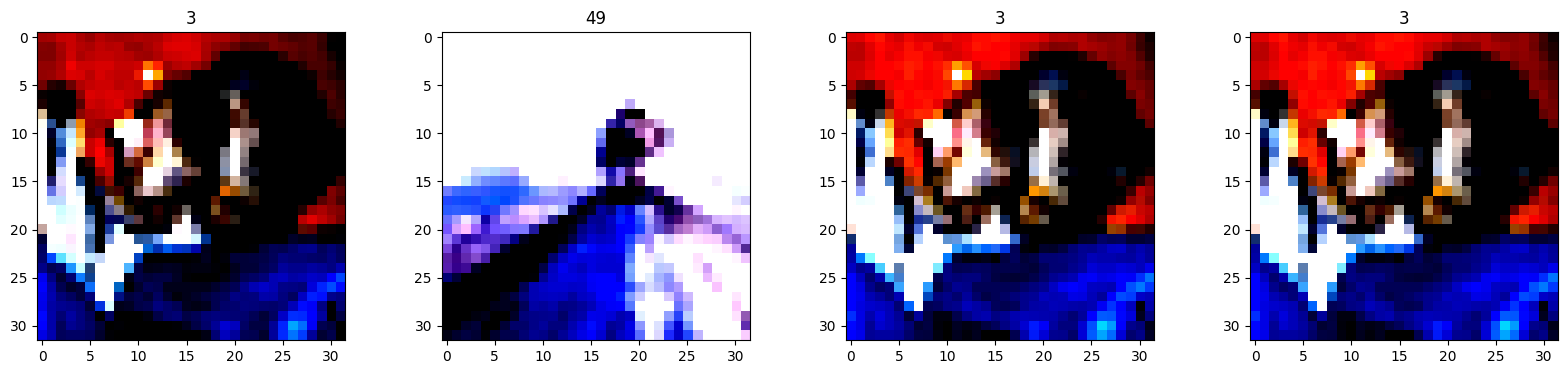

In [8]:
# image example
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ds = [cifar10, cifar100, cifar10c, cifar100c]
for i in range(4):
    ax[i].imshow(ds[i][0][0].permute(1, 2, 0))
    ax[i].set_title(ds[i][0][1])

In [4]:
def get_scores(model, dataloader):
    scores = torch.empty(10_000, dtype=torch.float32)
    idx = 0
    with torch.no_grad():
        for x, _ in tqdm(dataloader, "Computing scores"):
            x = x.to(device)
            y = model(x)
            y = torch.softmax(y, dim=1)
            scores[idx: idx + x.shape[0]] = torch.max(y, dim=1).values
            idx += x.shape[0]
    return scores

In [5]:
cifar10_scores = get_scores(model, cifar10_dataloader)
cifar100_scores = get_scores(model, cifar100_dataloader)
cifar10c_scores = get_scores(model, cifar10c_dataloader)
cifar100c_scores = get_scores(model, cifar100c_dataloader)

assert len(cifar10_scores) == len(cifar100_scores) == len(cifar10c_scores) == len(cifar100c_scores) == 10_000

Computing scores: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


/Users/dadalto/github/detectors/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:353: RuntimeWarning: overflow encountered in subtract
  return np.subtract(a, b, dtype=dt)
/Users/dadalto/github/detectors/.venv/lib/python3.10/site-packages/numpy/lib/histograms.py:851: RuntimeWarning: invalid value encountered in multiply
  f_indices = _unsigned_subtract(tmp_a, first_edge) * norm


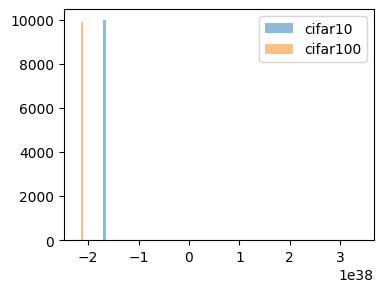

In [6]:
plt.figure(figsize=(4,3))
plt.hist(cifar10_scores.numpy(), bins=100, alpha=0.5, label="cifar10")
plt.hist(cifar100_scores.numpy(), bins=100, alpha=0.5, label="cifar100")
plt.legend()

In [20]:
results = detectors.eval.get_ood_results(cifar10_scores, cifar100_scores)
results_c = detectors.eval.get_ood_results(cifar10c_scores, cifar100c_scores)

print(results)
print(results_c)

/Users/dadalto/github/detectors/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│   1 results = detectors.eval.get_ood_results(cifar10_scores, cifar100_scores)                    │
│ ❱ 2 results_c = detectors.eval.get_ood_results(cifar10c_scores, cifar100c_scores)                │
│   3                                                                                              │
│   4 print(results)                                                                               │
│   5 print(results_c)                                                                             │
│                                                                                                  │
│ /Users/dadalto/github/detectors/src/detectors/eval.py:164 in get_ood_results                     │
│                                                                                                  │
│   161 │   _test_scores = torch.cat([in_scores, ood_scores]).cpu().numpy()                        │
│   162 │   _test_labels = torch.cat([in_labels, ood_labels]).cpu().numpy()                        │
│   163 │                                                                                          │
│ ❱ 164 │   fprs, tprs, thrs = sklearn.metrics.roc_curve(_test_labels, _test_scores)               │
│   165 │   precision, recall, _ = sklearn.metrics.precision_recall_curve(_test_labels, _test_sc   │
│   166 │   precision_out, recall_out, _ = sklearn.metrics.precision_recall_curve(_test_labels,    │
│   167 │   fpr, tpr, thr = fpr_at_fixed_tpr(fprs, tprs, thrs, 0.95)                               │
│                                                                                                  │
│ /Users/dadalto/github/detectors/.venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:9 │
│ 92 in roc_curve                                                                                  │
│                                                                                                  │
│    989 │   >>> thresholds                                                                        │
│    990 │   array([1.8 , 0.8 , 0.4 , 0.35, 0.1 ])                                                 │
│    991 │   """                                                                                   │
│ ❱  992 │   fps, tps, thresholds = _binary_clf_curve(                                             │
│    993 │   │   y_true, y_score, pos_label=pos_label, sample_weight=sample_weight                 │
│    994 │   )                                                                                     │
│    995                                                                                           │
│                                                                                                  │
│ /Users/dadalto/github/detectors/.venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:7 │
│ 55 in _binary_clf_curve                                                                          │
│                                                                                                  │
│    752 │   y_true = column_or_1d(y_true)                                                         │
│    753 │   y_score = column_or_1d(y_score)                                                       │
│    754 │   assert_all_finite(y_true)                                                             │
│ ❱  755 │   assert_all_finite(y_score)                                                            │
│    756 │                                                                                         │
│    757 │   # Filter out zero-weighted samples, as they should not impact the result              │
│    758 │   if sample_weight is not None:                   